<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/radon_dataset/WideDeepModel_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip show tensorflow

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, keras-preprocessing, tensorflow-estimator, h5py, astunparse, opt-einsum, tensorboard, grpcio, six, protobuf, wheel, gast, wrapt, numpy, scipy, termcolor, google-pasta
Required-by: fancyimpute


In [ ]:
import datetime
import os
import pprint

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow_datasets as tfds
from tensorflow.keras.experimental import LinearModel, WideDeepModel
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## データセット読み込み
- radonデータセット[https://www.tensorflow.org/datasets/catalog/radon](https://www.tensorflow.org/datasets/catalog/radon)

In [ ]:
def fetch_tf_dataset(data_name, 
                     split='train',
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  dataset, data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return dataset, data_info
  


data_name = 'radon' # @param{type:'string'}
x_name = 'features' # @param{type:'string'}
y_name = 'activity' # @param{type:'string'}
# インメモリでデータを読み込む
batch_size = -1

# データのフェッチ
tf_dataset, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=False,
                                     batch_size=batch_size)

display(ds_info)

tfds.core.DatasetInfo(
    name='radon',
    version=1.0.0,
    description='Radon is a radioactive gas that enters homes through contact
points with the ground. It is a carcinogen that is the primary cause of lung
cancer in non-smokers. Radon levels vary greatly from household to household.
This dataset contains measured radon levels in U.S homes by county and state.
The 'activity' label is the measured radon concentration in pCi/L. Important
predictors are 'floor' (the floor of the house in which the measurement was
taken), 'county' (the U.S. county in which the house is located), and 'Uppm' (a
measurement of uranium level of the soil by county).',
    homepage='http://www.stat.columbia.edu/~gelman/arm/examples/radon/',
    features=FeaturesDict({
        'activity': tf.float32,
        'features': FeaturesDict({
            'Uppm': tf.float32,
            'adjwt': tf.float32,
            'basement': tf.string,
            'cntyfips': tf.int32,
            'county': tf.string,
      

### Dataframeに変換

In [ ]:
%%time

def convert_tfds_to_df(tf_ds, x_key, y_key):
  '''tf DatasetをDataframeに変換'''
  
  # yについて{key:numpy}形式のdictに変換
  y = {}
  y[y_key] = tf_ds[y_key].numpy()

  # xについて[{key:numpy},{key:numpy},,,]形式のdictに変換
  x = {}
  for f_key, element in tf_ds[x_key].items():
    if element.dtype == 'string':
      x[f_key] = _convert_byte_np_to_string_np(bytes_np=element.numpy())
    else:
      x[f_key] = element.numpy()
  
  y_df = pd.DataFrame.from_dict(y)
  x_df = pd.DataFrame.from_dict(x)
  df = pd.concat([y_df, x_df], axis=1)

  return df


def _convert_byte_np_to_string_np(bytes_np, decode_char='utf-8'):
  '''バイナリ文字列形式のnumpy配列を文字列形式のnumpy配列に変換'''
  decode_np = np.array([])
  for b in bytes_np:
    decode_np = np.append(decode_np, b.decode(decode_char))
  decode_np = decode_np.astype('object')
  return decode_np


# tf datasetからDataframeに変換
dataset = convert_tfds_to_df(tf_dataset, x_key=x_name, y_key=y_name)


display(dataset.head())
display(dataset.shape)


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,activity,Uppm,adjwt,basement,cntyfips,county,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,state,state2,stfips,stopdt,stoptm,stratum,typebldg,wave,windoor,zip,zipflag
0,1.6,2.49759,292.219543,N,3,ALLEN,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,IN,IN,18,11689,2235,2,1,92,,46835,0
1,0.5,2.66527,364.958313,N,25,YAVAPAI,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,AZ,AZ,4,22888,1010,2,1,56,,86325,0
2,3.0,2.43343,626.564575,Y,17,MIDDLESEX,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,MA,MA,25,32488,1000,1,1,23,,1778,0
3,0.6,2.43343,570.611755,N,17,MIDDLESEX,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,MA,MA,25,32688,1200,1,1,62,,1432,0
4,1.2,2.10811,426.798859,Y,95,JACKSON,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,MO,MO,29,32488,610,2,1,91,,64134,0


(12573, 28)

'y_col:activity'

"x_cols num:27, names:Index(['Uppm', 'adjwt', 'basement', 'cntyfips', 'county', 'dupflag', 'floor',\n       'idnum', 'lat', 'lon', 'pcterr', 'region', 'rep', 'room', 'startdt',\n       'starttm', 'state', 'state2', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'windoor', 'zip', 'zipflag'],\n      dtype='object')"

CPU times: user 4.54 s, sys: 326 ms, total: 4.86 s
Wall time: 4.88 s


## 文字列をone-hotエンコード

In [ ]:
%%time

def one_hot_encode_df_val(df, target_col):
  '''文字列のカラムをone-hot-encodeしたカラムに置き換え
  INFO :　新規のカラムは先頭に挿入していく
  WARNING : target_colはdropされる
  '''
  mlb = MultiLabelBinarizer()
  one_hot_feature = mlb.fit_transform([{str(val)} for val in df[target_col].values])
  insert_columns = [target_col+'_'+str(x+1) for x in range(len(one_hot_feature[0]))]
  insert_df = pd.DataFrame(one_hot_feature, columns=insert_columns)
  df = df.drop(columns=target_col)
  df = pd.concat([insert_df, df], axis=1)
  return df

encode_cols = ['basement', 'county', 'state', 'state2', 'windoor']
for col in encode_cols:
  dataset = one_hot_encode_df_val(dataset, col)
display(dataset.head())


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,windoor_1,state2_1,state2_2,state2_3,state2_4,state2_5,state2_6,state2_7,state2_8,state2_9,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,county_1,county_2,county_3,county_4,county_5,county_6,county_7,county_8,county_9,county_10,county_11,county_12,county_13,county_14,county_15,county_16,county_17,county_18,county_19,county_20,county_21,county_22,...,county_374,county_375,county_376,county_377,county_378,county_379,county_380,county_381,county_382,county_383,county_384,county_385,county_386,basement_1,basement_2,basement_3,basement_4,activity,Uppm,adjwt,cntyfips,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,stfips,stopdt,stoptm,stratum,typebldg,wave,zip,zipflag
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.6,2.49759,292.219543,3,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,18,11689,2235,2,1,92,46835,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.5,2.66527,364.958313,25,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,4,22888,1010,2,1,56,86325,0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,2.43343,626.564575,17,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,25,32488,1000,1,1,23,1778,0
3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.6,2.43343,570.611755,17,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,25,32688,1200,1,1,62,1432,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.2,2.10811,426.798859,95,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,29,32488,610,2,1,91,64134,0


'y_col:activity'

"x_cols num:430, names:Index(['windoor_1', 'state2_1', 'state2_2', 'state2_3', 'state2_4', 'state2_5',\n       'state2_6', 'state2_7', 'state2_8', 'state2_9',\n       ...\n       'startdt', 'starttm', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'zip', 'zipflag'],\n      dtype='object', length=430)"

CPU times: user 455 ms, sys: 21.4 ms, total: 476 ms
Wall time: 480 ms


## データ分割

In [ ]:
SEED = 7 #@param{type:'number'}

X_train, X_test, y_train, y_test = train_test_split(dataset[x_cols], dataset[y_col],
                                                    test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=SEED)

display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
display(X_test.shape, y_test.shape)

(8046, 430)

(8046,)

(2012, 430)

(2012,)

(2515, 430)

(2515,)

## WideDeepモデル作成

In [ ]:
%%time
def take_dnn_cols(X_cols, linear_cols):
    '''DNN用のカラム名を返す
    INFO : WideDeepModel用'''
    return set(X_cols) ^ set(linear_cols)


def WideDeep_fn(X_train_dnn, input_shape_dnn, dropout_seed_dnn):
    '''WideDeepModelの定義'''

    def _LinearModel_fn():
        '''線形回帰モデルの定義'''
        linear_model = LinearModel()
        return linear_model

    def _DNNModel_fn(input_shape, dropout_seed, X_train):
        '''DNNモデルの定義'''

        def _initialize_std_layer(X_train):
            '''標準化層の初期化'''
            norm_layer = Normalization()
            norm_layer.adapt(X_train)
            return norm_layer
        
        dnn_model = Sequential()
        dnn_model.add(Input(shape=input_shape))
        
        # 標準化レイヤーの追加
        std_layer = _initialize_std_layer(X_train)
        dnn_model.add(std_layer)

        # データ解析レイヤーの追加
        dnn_model.add(layers.Dense(units=64, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))
        dnn_model.add(layers.Dense(units=128, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))

        # 出力レイヤーの追加
        dnn_model.add(layers.Dense(units=1))
        return dnn_model


    linear_model = _LinearModel_fn()
    dnn_model = _DNNModel_fn(input_shape=input_shape_dnn, 
                             dropout_seed=dropout_seed_dnn,
                             X_train=X_train_dnn)
    
    combined_model = WideDeepModel(linear_model, dnn_model)

    # 勾配アルゴリズム(線形モデル用, 深層モデル用), 損失関数, 評価関数
    combined_model.compile(optimizer=['sgd', 'adam'],loss='mse', metrics=['RootMeanSquaredError'])
    
    return combined_model


# DNNモデルの入力に使用する特徴量の取得
X_cols = list(ds_info.features['features'].keys())
dnn_cols = take_dnn_cols(X_cols=X_cols, linear_cols=encode_cols)
X_train_dnn = X_train.loc[:, dnn_cols].values,
dnn_input_shape = (X_train.loc[:, dnn_cols].shape[1], )

# 線形回帰モデルが使用する特徴量名の取得
linear_cols = X_train.drop(columns=dnn_cols).columns


# モデル定義
regressor = WideDeep_fn(X_train_dnn=X_train_dnn, 
                        input_shape_dnn=dnn_input_shape,
                        dropout_seed_dnn=SEED)

display(regressor)


def X_data_WideDeep_fn(X_df, linear_cols, dnn_cols):
    '''WideDeepモデル用の特徴量データセットの作成'''
    return [X_df[linear_cols].values, X_df[dnn_cols].values]


X_train_WideDeep = X_data_WideDeep_fn(X_df=X_train, linear_cols=linear_cols, dnn_cols=dnn_cols)
X_val_WideDeep = X_data_WideDeep_fn(X_df=X_val, linear_cols=linear_cols, dnn_cols=dnn_cols)
X_test_WideDeep = X_data_WideDeep_fn(X_df=X_test, linear_cols=linear_cols, dnn_cols=dnn_cols)

CPU times: user 157 ms, sys: 2.99 ms, total: 160 ms
Wall time: 159 ms


In [ ]:
EPOCH =   700#@param{type:'number'}
BATCH_SIZE = 256 #@param{type:'number'}

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=5)

In [ ]:
%%time
regressor.fit(x=X_train_WideDeep,
              y=y_train.values,
              epochs=EPOCH,
              batch_size=BATCH_SIZE,
              validation_data=(X_val_WideDeep, y_val.values),
              callbacks=[es]
              )

Epoch 1/700
32/32 [==============================] - 0s 10ms/step - loss: 97.0613 - root_mean_squared_error: 9.8840 - val_loss: 74.3943 - val_root_mean_squared_error: 8.6164
Epoch 2/700
32/32 [==============================] - 0s 5ms/step - loss: 93.9280 - root_mean_squared_error: 9.6929 - val_loss: 73.8273 - val_root_mean_squared_error: 8.5833
Epoch 3/700
32/32 [==============================] - 0s 4ms/step - loss: 93.5501 - root_mean_squared_error: 9.4780 - val_loss: 73.7041 - val_root_mean_squared_error: 8.5761
Epoch 4/700
32/32 [==============================] - 0s 4ms/step - loss: 93.4357 - root_mean_squared_error: 9.6735 - val_loss: 73.6575 - val_root_mean_squared_error: 8.5733
Epoch 5/700
32/32 [==============================] - 0s 4ms/step - loss: 93.3695 - root_mean_squared_error: 9.6715 - val_loss: 73.7050 - val_root_mean_squared_error: 8.5761
Epoch 6/700
32/32 [==============================] - 0s 4ms/step - loss: 93.3346 - root_mean_squared_error: 9.6904 - val_loss: 73.6560

# モデルの構造を可視化

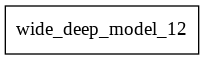

Model: "wide_deep_model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_model_13 (LinearModel multiple                  409       
_________________________________________________________________
sequential_13 (Sequential)   (1, None, 1)              9966      
Total params: 10,375
Trainable params: 10,330
Non-trainable params: 45
_________________________________________________________________


None

In [ ]:
def display_model(model):
    '''モデルの構造を表示'''
    display(plot_model(model))
    display(model.summary())

display_model(model=regressor)

## モデルの評価

### Kerasの組み込み評価関数

In [ ]:
%%time
score = regressor.evaluate(x=X_test_WideDeep, y=y_test, batch_size=BATCH_SIZE)
display('loss : {}, metric : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 2ms/step - loss: 70.1850 - root_mean_squared_error: 8.3778


'loss : 70.18504333496094, metric : 8.377843856811523'

CPU times: user 80.2 ms, sys: 2.93 ms, total: 83.1 ms
Wall time: 81.1 ms


In [ ]:
# predict_on_batchメソッドだとバッチ推論可能
regressor.predict_on_batch(X_test_WideDeep)

array([[[4.4957223],
        [4.50909  ],
        [4.527225 ],
        ...,
        [4.4551497],
        [4.587219 ],
        [4.341889 ]]], dtype=float32)

### sklearnの評価関数

In [ ]:
%%time
def _calc_score(y_true, y_pred, sklearn_metric):
  '''sklearnの評価指標のスコアを計算'''
  score = sklearn_metric(y_true=y_true, y_pred=y_pred)
  return score


def evaluete_sk_metrics(y_true, y_pred, sklearn_metrics):
  '''sklearnの各種、評価関数を使用'''
  result = {}
  for sk_metric in sklearn_metrics:
    result[sk_metric.__name__] = _calc_score(y_true=y_true, y_pred=y_pred, sklearn_metric=sk_metric)
  return result


SK_METRICS=[r2_score, explained_variance_score, mean_squared_error]
eval_scores = {'train': {}, 'val': {}, 'test': {}}

for key, X, y_true in zip(['train', 'val', 'test'], [X_train_WideDeep, X_val_WideDeep, X_test_WideDeep], [y_train, y_val, y_test]):
  y_pred = regressor.predict_on_batch(x=X)[0]
  eval_scores[key] = evaluete_sk_metrics(y_true=y_true, y_pred=y_pred, sklearn_metrics=SK_METRICS)
pprint.pprint(eval_scores)

{'test': {'explained_variance_score': 0.0018113255500793457,
          'mean_squared_error': 70.0462,
          'r2_score': 0.0016165912747656552},
 'train': {'explained_variance_score': 0.0014396309852600098,
           'mean_squared_error': 92.93496,
           'r2_score': 0.0014384219800466225},
 'val': {'explained_variance_score': 0.0027590394020080566,
         'mean_squared_error': 73.3762,
         'r2_score': 0.0025483242614464663}}
CPU times: user 233 ms, sys: 12.4 ms, total: 245 ms
Wall time: 218 ms
